UPSAMPLING PREDICING EMAIL SPAM

#Imports/Helper functions

In [ ]:
# basic imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
%matplotlib inline

# data processing 
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# get predictions from the best perfomming model
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score ,roc_auc_score
from sklearn.metrics import precision_score , recall_score , roc_curve


# text processing
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.tokenize import word_tokenize 


# deep learning libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Masking

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# function to draw graph results for the model
def plot_performance(history , Model_name):
    fig , ax = plt.subplots(1,2 , figsize =(12 ,6))
    ax[0].set_title(f"Accuracy Perfomance Analysis for {Model_name}" , c='red')
    ax[1].set_title(f"Loss Perfomance Analysis for {Model_name}" , c='red')
    ax[0].plot(history.history['acc'] , label ='train accuracy' , c='g')
    ax[0].plot(history.history['val_acc'] , label ='val accuracy' , c='orange')
    ax[1].set_ylabel('Accuracy' , fontsize =15)
    ax[1].set_xlabel('epochs' , fontsize =15)
    ax[1].plot(history.history['loss'] , label ='train loss' , c ='yellow')
    ax[1].plot(history.history['val_loss'] , label ='val loss' , c ='red')
    ax[1].set_ylabel('Loss' , fontsize =15)
    ax[1].set_xlabel('epoch' , fontsize =15)
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')

In [ ]:
def evaluate_model_performance(model_name, test_set):
     
    preds_probs = model_name.predict(test_set)
    #evaluate the real class labels
    preds_labels= [1 if x>=0.5 else 0 for x in preds_probs]

    actual_labels =y_test
    print(f"\n*****Evaluating {type} Models Score using various metrics************\n")
    print(f"\t\tAccuracy is  {accuracy_score(actual_labels , preds_labels)}")
    print(f"\t\tPrecision Score is  {precision_score(actual_labels , preds_labels)}")
    print(f"\t\tRecall Score is  {recall_score(actual_labels , preds_labels)}")
    print(f"\t\tF1 Score is  {f1_score(actual_labels , preds_labels)}\n\n\n")


    # draw confusion matrix to show results
    c_matrix1 = confusion_matrix(actual_labels , preds_labels)
    sns.heatmap(c_matrix1 , annot= True , annot_kws={"size": 10} ,fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")


In [ ]:
def plot_graphs(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

In [ ]:
def lemma(input_string):
  lemma_word = []
  word_tokens = word_tokenize(input_string)
  for w in word_tokens:
    w1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
    w2 = wordnet_lemmatizer.lemmatize(w1, pos = "v")
    w3 = wordnet_lemmatizer.lemmatize(w2, pos = "a")
    lemma_word.append(w3)
  joined_string = ' '.join(lemma_word)
  return joined_string

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  no_punctuations = tf.strings.regex_replace(lowercase, r'[^\w\s]', ' ')
  no_stop = no_punctuations
  for stopwords in stop:
    no_stop = tf.strings.regex_replace(no_stop, ' '+stopwords+' ', ' ')
  return no_stop

# Retrieving the dataset and converting it to a dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/Taiga83/Spam-Detection-Project/main/SMSSpamCollection'
messages = pd.read_csv(url, sep='\t', names=['Label', 'Message'])
messages.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#

In [ ]:
# Get all the ham and spam text
ham = messages[messages.Label =='ham']
spam = messages[messages.Label =='spam']
# Convert to string
ham_string = " ".join(ham.Message.to_numpy().tolist())
spam_string = " ".join(spam.Message.to_numpy().tolist())

#Dataset visualization

##Ham wordcloud

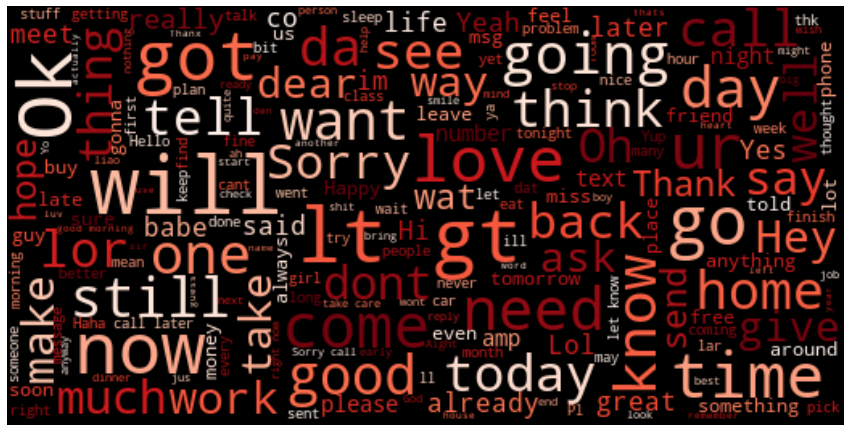

In [ ]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds').generate(ham_string)
plt.figure(figsize=(15,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Spam wordcloud

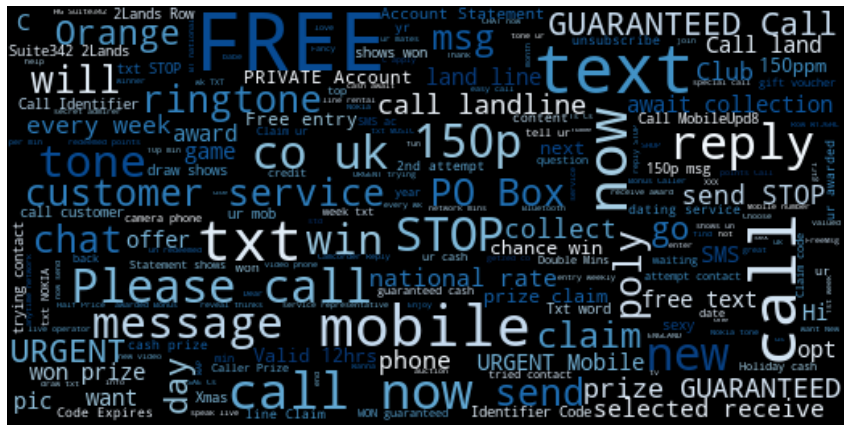

In [ ]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_string)
plt.figure(figsize=(15,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

##View split between ham and spam

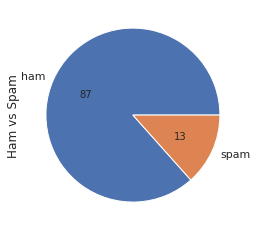

In [ ]:
messages.groupby('Label').size().plot(kind='pie', y='Label', label='Ham vs Spam', autopct='%.0f')

#  Dense model for data upsampled via random copying

## Data pre-processing

### Rebalance data

In [ ]:
now = datetime.now()
spam_rebalanced = resample(spam, replace=True, n_samples=len(ham), random_state=now.hour + now.minute + now.second) 
print(f'Shape of spam dataset after rebalancing: {spam_rebalanced.shape}')
print(f'Shape of ham dataset: {ham.shape}')

Shape of spam dataset after rebalancing: (4825, 2)
Shape of ham dataset: (4825, 2)


In [ ]:
frames = [spam_rebalanced, ham]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                 Message
count   9650                    9650
unique     2                    5169
top     spam  Sorry, I'll call later
freq    4825                      30
Average number of characters = 105


###  Lemmatization

In [ ]:
print(combined_df['Message'][95])

95    Your free ringtone is waiting to be collected....
95    Your free ringtone is waiting to be collected....
95    Your free ringtone is waiting to be collected....
95    Your free ringtone is waiting to be collected....
95    Your free ringtone is waiting to be collected....
Name: Message, dtype: object


In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

In [ ]:
print(combined_df['Message'][95])

95    Your free ringtone be wait to be collect . Sim...
95    Your free ringtone be wait to be collect . Sim...
95    Your free ringtone be wait to be collect . Sim...
95    Your free ringtone be wait to be collect . Sim...
95    Your free ringtone be wait to be collect . Sim...
Name: Message, dtype: object


### Vectorization and padding

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

60.0% of the dataset is being used for training
20.0% of the dataset is being used for testing
20.0% of the dataset is being used for validation


In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab, standardize=custom_standardization)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model training and evaluation

In [ ]:
embedding_dim = 16
drop_value = 0.2 
n_dense = 24

In [ ]:
model = tf.keras.models.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim),
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(n_dense, activation='relu'),
    tf.keras.layers.Dropout(drop_value),
    tf.keras.layers.Dense(1, activation='sigmoid')                     
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 masking (Masking)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
num_epochs = 25
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train, epochs=num_epochs, validation_data=(x_val, y_val),callbacks=[early_stop], verbose=2)

Epoch 1/25
181/181 - 6s - loss: 0.6867 - accuracy: 0.6288 - val_loss: 0.6790 - val_accuracy: 0.7679 - 6s/epoch - 34ms/step
Epoch 2/25
181/181 - 2s - loss: 0.6706 - accuracy: 0.7663 - val_loss: 0.6578 - val_accuracy: 0.8207 - 2s/epoch - 13ms/step
Epoch 3/25
181/181 - 1s - loss: 0.6458 - accuracy: 0.8206 - val_loss: 0.6270 - val_accuracy: 0.8430 - 1s/epoch - 7ms/step
Epoch 4/25
181/181 - 1s - loss: 0.6113 - accuracy: 0.8378 - val_loss: 0.5885 - val_accuracy: 0.8503 - 1s/epoch - 7ms/step
Epoch 5/25
181/181 - 1s - loss: 0.5723 - accuracy: 0.8518 - val_loss: 0.5442 - val_accuracy: 0.8642 - 1s/epoch - 7ms/step
Epoch 6/25
181/181 - 1s - loss: 0.5266 - accuracy: 0.8608 - val_loss: 0.4966 - val_accuracy: 0.8674 - 1s/epoch - 7ms/step
Epoch 7/25
181/181 - 1s - loss: 0.4819 - accuracy: 0.8696 - val_loss: 0.4524 - val_accuracy: 0.8751 - 1s/epoch - 7ms/step
Epoch 8/25
181/181 - 1s - loss: 0.4393 - accuracy: 0.8805 - val_loss: 0.4110 - val_accuracy: 0.8865 - 1s/epoch - 7ms/step
Epoch 9/25
181/181 - 1

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

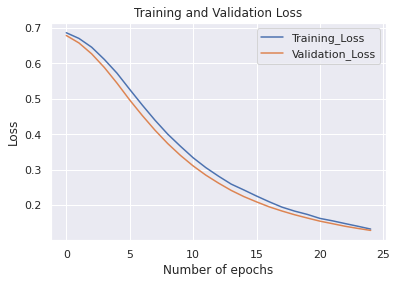

In [ ]:
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss')

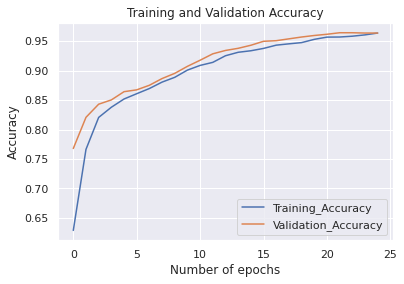

In [ ]:
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy')


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.9554404145077721
		Precision Score is  0.9221032132424537
		Recall Score is  0.993704092339979
		F1 Score is  0.9565656565656565





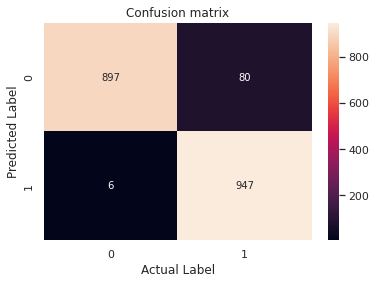

In [ ]:
evaluate_model_performance(model, x_test)

# Dense model for data upsampled via Smote

## Data pre-processing

### Get copy of dataset

In [ ]:
max_vocab = 1000
messages_copy = messages.copy(deep=True)
messages_copy['Label'] = messages_copy['Label'].map({'spam': 0, 'ham': 1})

### Lemmamization

In [ ]:
messages_copy['Message'] = messages_copy['Message'].apply(lemma)

### Vectorization

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab, standardize=custom_standardization)
vectorize_layer.adapt(messages_copy['Message'].to_numpy())

### Upsampling spam dataset and downsampling ham dataset

In [ ]:
now = datetime.now()
su = SMOTE(random_state=now.hour + now.minute + now.second, sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', su), ('u', under)]
pipeline = Pipeline(steps=steps)

vectorize_messages = vectorize_layer(messages_copy['Message'].to_numpy()).numpy()
message_su, label_su = pipeline.fit_resample(vectorize_messages, messages_copy[['Label']])

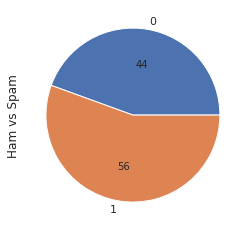

In [ ]:
label_su.groupby('Label').size().plot(kind='pie', y='Label', label='Ham vs Spam', autopct='%.0f')

In [ ]:
now = datetime.now()
x_train, x_test, y_train, y_test = train_test_split(message_su, label_su, test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=now.hour + now.minute + now.second)

## Model training and evaluation

In [ ]:
embedding_dim = 16
drop_value = 0.2 
n_dense = 24

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim),
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(n_dense, activation='relu'),
    tf.keras.layers.Dropout(drop_value),
    tf.keras.layers.Dense(1, activation='sigmoid')                     
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          16000     
                                                                 
 masking_1 (Masking)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                      

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
num_epochs = 25
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train, epochs=num_epochs, validation_data=(x_test, y_test),callbacks=[early_stop], verbose=2)

Epoch 1/25
41/41 - 1s - loss: 0.6896 - accuracy: 0.5430 - val_loss: 0.6855 - val_accuracy: 0.5563 - 1s/epoch - 27ms/step
Epoch 2/25
41/41 - 0s - loss: 0.6811 - accuracy: 0.5614 - val_loss: 0.6769 - val_accuracy: 0.5563 - 210ms/epoch - 5ms/step
Epoch 3/25
41/41 - 0s - loss: 0.6703 - accuracy: 0.5607 - val_loss: 0.6627 - val_accuracy: 0.5540 - 199ms/epoch - 5ms/step
Epoch 4/25
41/41 - 0s - loss: 0.6488 - accuracy: 0.5691 - val_loss: 0.6364 - val_accuracy: 0.5678 - 185ms/epoch - 5ms/step
Epoch 5/25
41/41 - 0s - loss: 0.6145 - accuracy: 0.6590 - val_loss: 0.5932 - val_accuracy: 0.7770 - 174ms/epoch - 4ms/step
Epoch 6/25
41/41 - 0s - loss: 0.5609 - accuracy: 0.7842 - val_loss: 0.5381 - val_accuracy: 0.8046 - 192ms/epoch - 5ms/step
Epoch 7/25
41/41 - 0s - loss: 0.4998 - accuracy: 0.8287 - val_loss: 0.4818 - val_accuracy: 0.8529 - 163ms/epoch - 4ms/step
Epoch 8/25
41/41 - 0s - loss: 0.4400 - accuracy: 0.8472 - val_loss: 0.4300 - val_accuracy: 0.8483 - 153ms/epoch - 4ms/step
Epoch 9/25
41/41 -

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training Loss', 'accuracy': 'Training Accuracy', 'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'}, inplace = True)

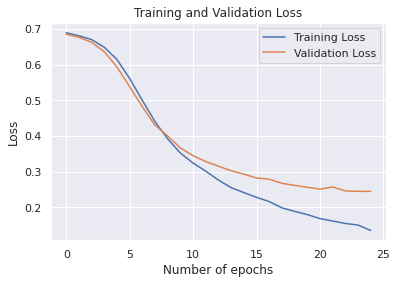

In [ ]:
plot_graphs('Training Loss', 'Validation Loss', 'Loss')

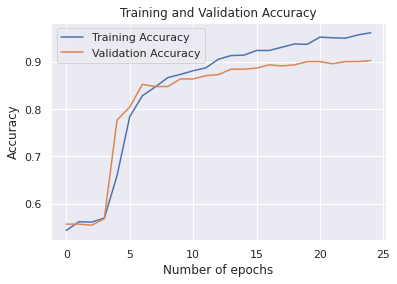

In [ ]:
plot_graphs('Training Accuracy', 'Validation Accuracy', 'Accuracy')


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.903448275862069
		Precision Score is  0.8731343283582089
		Recall Score is  0.9669421487603306
		F1 Score is  0.9176470588235294





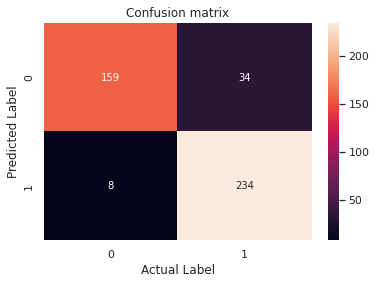

In [ ]:
evaluate_model_performance(model, x_test)

# LSTM model w/upsampling via random copying

## Data pre-processing

### Rebalance data

In [ ]:
now = datetime.now()
spam_rebalanced = resample(spam, replace=True, n_samples=len(ham), random_state=now.hour + now.minute + now.second) 
print(f'Shape of spam dataset after rebalancing: {spam_rebalanced.shape}')
print(f'Shape of ham dataset: {ham.shape}')

Shape of spam dataset after rebalancing: (4825, 2)
Shape of ham dataset: (4825, 2)


In [ ]:
frames = [spam_rebalanced, ham]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                 Message
count   9650                    9650
unique     2                    5169
top     spam  Sorry, I'll call later
freq    4825                      30
Average number of characters = 104


###  Lemmatization

In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

### Vectorization and padding

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

60.0% of the dataset is being used for training
20.0% of the dataset is being used for testing
20.0% of the dataset is being used for validation


In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab, standardize=custom_standardization)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model training and evaluation

In [ ]:
embedding_dim = 16
drop_value = 0.2 

In [ ]:
# define lstm model


lstm_model = tf.keras.models.Sequential()
#add embedding
# Embedding (input_dim: size of vocabolary, 
# output_dim: dimension of dense embedding, 
# input_length: length of input sequence)
lstm_model.add(vectorize_layer)
lstm_model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim))
lstm_model.add(Masking(mask_value=0))
lstm_model.add(LSTM(20, dropout=drop_value, return_sequences=True))
lstm_model.add(LSTM(8))
lstm_model.add(Dense(1, activation='sigmoid'))
# check model summary
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 16)          16000     
                                                                 
 masking_2 (Masking)         (None, None, 16)          0         
                                                                 
 lstm_4 (LSTM)               (None, None, 20)          2960      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 928       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                      

In [ ]:
# compile the lstm model and train it
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])

# define callback for regulator
early_stopping = EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=10,
        mode='max')
    

lstm_history = lstm_model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val),callbacks=[early_stopping], verbose=2)


Epoch 1/25
181/181 - 21s - loss: 0.6892 - acc: 0.5454 - val_loss: 0.6763 - val_acc: 0.7031 - 21s/epoch - 118ms/step
Epoch 2/25
181/181 - 8s - loss: 0.5836 - acc: 0.7637 - val_loss: 0.4274 - val_acc: 0.8699 - 8s/epoch - 43ms/step
Epoch 3/25
181/181 - 8s - loss: 0.3322 - acc: 0.9259 - val_loss: 0.2763 - val_acc: 0.9461 - 8s/epoch - 43ms/step
Epoch 4/25
181/181 - 8s - loss: 0.2427 - acc: 0.9551 - val_loss: 0.2171 - val_acc: 0.9606 - 8s/epoch - 47ms/step
Epoch 5/25
181/181 - 8s - loss: 0.1881 - acc: 0.9679 - val_loss: 0.1807 - val_acc: 0.9658 - 8s/epoch - 43ms/step
Epoch 6/25
181/181 - 8s - loss: 0.1648 - acc: 0.9689 - val_loss: 0.1700 - val_acc: 0.9627 - 8s/epoch - 43ms/step
Epoch 7/25
181/181 - 8s - loss: 0.1432 - acc: 0.9748 - val_loss: 0.1476 - val_acc: 0.9699 - 8s/epoch - 42ms/step
Epoch 8/25
181/181 - 9s - loss: 0.1282 - acc: 0.9767 - val_loss: 0.1336 - val_acc: 0.9725 - 9s/epoch - 49ms/step
Epoch 9/25
181/181 - 8s - loss: 0.1147 - acc: 0.9784 - val_loss: 0.1146 - val_acc: 0.9777 - 8

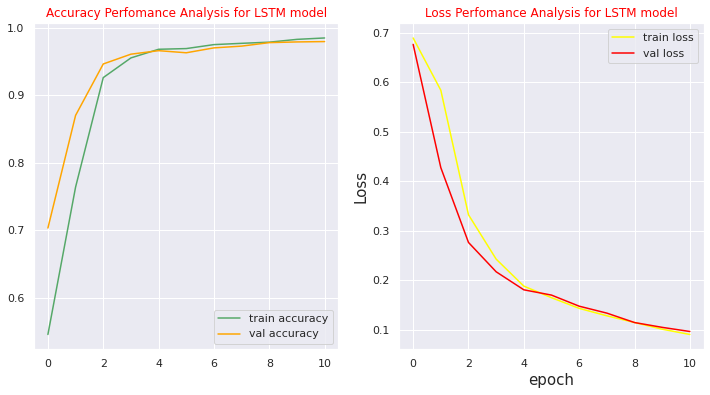

In [ ]:
# check the lstm model permomance 
plot_performance(lstm_history , "LSTM model")

In [ ]:
# evaluate the model accuracy
loss , accuracy = lstm_model.evaluate(x_test , y_test)
print("*************Evaluation On LSTM MODEL***************\n")
print(f"\tThe Model Accuracy is {np.round(accuracy*100 ,3)}%")
print(f"\tThe Model Loss is {np.round(loss ,4)}")

61/61 [==============================] - 1s 12ms/step - loss: 0.1021 - acc: 0.9782
*************Evaluation On LSTM MODEL***************

	The Model Accuracy is 97.824%
	The Model Loss is 0.1021



*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.9782383419689119
		Precision Score is  0.9726775956284153
		Recall Score is  0.9812568908489526
		F1 Score is  0.9769484083424808





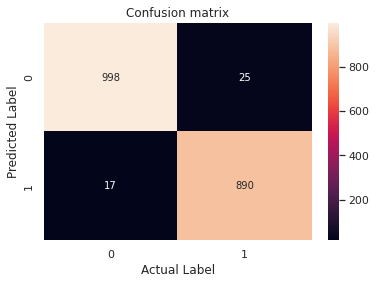

In [ ]:
evaluate_model_performance(lstm_model, x_test)

# BiLSTM Model w/upsampling via random copying

## Data pre-processing

### Rebalance data

In [ ]:
now = datetime.now()
spam_rebalanced = resample(spam, replace=True, n_samples=len(ham), random_state=now.hour + now.minute + now.second) 
print(f'Shape of spam dataset after rebalancing: {spam_rebalanced.shape}')
print(f'Shape of ham dataset: {ham.shape}')

Shape of spam dataset after rebalancing: (4825, 2)
Shape of ham dataset: (4825, 2)


In [ ]:
frames = [spam_rebalanced, ham]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                                            Message
count   9650                                               9650
unique     2                                               5167
top     spam  Please call our customer service representativ...
freq    4825                                                 32
Average number of characters = 105


###  Lemmatization

In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

### Vectorization and padding

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

60.0% of the dataset is being used for training
20.0% of the dataset is being used for testing
20.0% of the dataset is being used for validation


In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab, standardize=custom_standardization)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model training and evaulation

In [ ]:
embedding_dim = 16
drop_value = 0.2 

In [ ]:
# define bidirectional LSTM  model

blstm_model = tf.keras.models.Sequential()
blstm_model.add(vectorize_layer)
blstm_model.add(Embedding(max_vocab, embedding_dim))
blstm_model.add(Masking(mask_value=0))
blstm_model.add(Bidirectional(LSTM(20, return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(8)))
blstm_model.add(Dropout(drop_value))
blstm_model.add(Dense(1, activation='sigmoid'))
# check the blstm model summary

blstm_model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, None, 16)          16000     
                                                                 
 masking_3 (Masking)         (None, None, 16)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 40)         5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               3136      
 nal)                                                            
                                                      

In [ ]:
# compile the blstm model and train it

blstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
blstm_history = blstm_model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val),callbacks=[early_stopping], verbose=2)


Epoch 1/25
181/181 - 44s - loss: 0.6689 - acc: 0.6648 - val_loss: 0.6151 - val_acc: 0.6896 - 44s/epoch - 241ms/step
Epoch 2/25
181/181 - 11s - loss: 0.5266 - acc: 0.8017 - val_loss: 0.4191 - val_acc: 0.8482 - 11s/epoch - 59ms/step
Epoch 3/25
181/181 - 11s - loss: 0.3233 - acc: 0.8981 - val_loss: 0.2322 - val_acc: 0.9368 - 11s/epoch - 60ms/step
Epoch 4/25
181/181 - 11s - loss: 0.1848 - acc: 0.9591 - val_loss: 0.1518 - val_acc: 0.9668 - 11s/epoch - 59ms/step
Epoch 5/25
181/181 - 11s - loss: 0.1354 - acc: 0.9713 - val_loss: 0.1191 - val_acc: 0.9741 - 11s/epoch - 59ms/step
Epoch 6/25
181/181 - 11s - loss: 0.1088 - acc: 0.9788 - val_loss: 0.1071 - val_acc: 0.9762 - 11s/epoch - 60ms/step
Epoch 7/25
181/181 - 11s - loss: 0.0904 - acc: 0.9831 - val_loss: 0.0960 - val_acc: 0.9788 - 11s/epoch - 60ms/step
Epoch 8/25
181/181 - 12s - loss: 0.0791 - acc: 0.9860 - val_loss: 0.0874 - val_acc: 0.9808 - 12s/epoch - 64ms/step
Epoch 9/25
181/181 - 11s - loss: 0.0712 - acc: 0.9874 - val_loss: 0.0836 - val_

In [ ]:
# evaluate the model accuracy
loss , accuracy = blstm_model.evaluate(x_test , y_test)
print("*************Evaluation On BLSTM MODEL***************\n")
print(f"\tThe Model Accuracy is {np.round(accuracy*100 ,3)}%")
print(f"\tThe Model Loss is {np.round(loss ,4)}")

61/61 [==============================] - 1s 17ms/step - loss: 0.0678 - acc: 0.9865
*************Evaluation On BLSTM MODEL***************

	The Model Accuracy is 98.653%
	The Model Loss is 0.0678


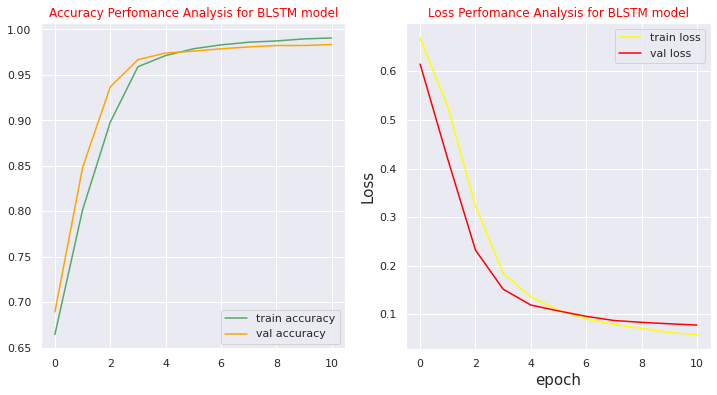

In [ ]:
# plot accuracy and losses summary
plot_performance(blstm_history , "BLSTM model")


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.9865284974093265
		Precision Score is  0.9840764331210191
		Recall Score is  0.988272921108742
		F1 Score is  0.9861702127659575





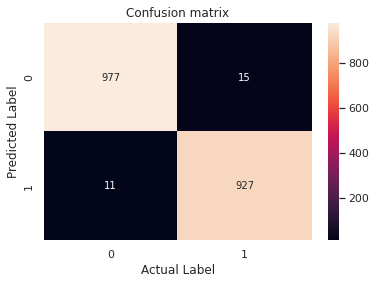

In [ ]:
# check evaluation summary
evaluate_model_performance(blstm_model, x_test)